In [1]:
import re
import json
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
import networkx as nx
import matplotlib.pyplot as plt
from collections import namedtuple
from __future__ import division
from math import log
from operator import itemgetter

In [2]:
gryffindor = "#CE0E00"
slytherin = "#009403"
hufflepuff = "#FFCA52"
ravenclaw = "#6596BF"
muggle = "#cccccc"
default = "#4e0333"
order= "#fa5b0b"
deatheater = "#002f01"

In [3]:
save_plots = True

In [4]:
movie_data = namedtuple('movie', 'scenes, occurrences')

In [5]:
word_tokenizer = RegexpTokenizer(r'(\w+[-|\']?\w*)')

In [6]:
def script_to_secnens_dict(file_name):
    script = open(file_name,"r").read().decode("utf-8")
    scenes = defaultdict(str)
    matches = regex.finditer(script)
    for match in matches:
        sceneId = match.group(1)
        dialog = match.group(2)
        scenes[sceneId] += dialog
    return scenes

In [7]:
def process_script(script, tokenizer, name_mappings, special_cases=[], ignore=[]):
    occurrences = defaultdict(set)
    #divide script into scenes ignore the title, introduction, revisions, etc. 
    scenes = script.split("_START OF NEW SCENE_")[1:]
    
    for index, scene in enumerate(scenes):
        text = scene.lower()
        tokens = tokenizer.tokenize(text)

        for key, name in special_cases.iteritems():
            if key in ignore:
                continue
            elif key in scene:
                occurrences[index].add(special_cases[key])

        for token in tokens:
            if token in ignore:
                continue
            elif name_mappings.has_key(token):
                occurrences[index].add(name_mappings[token][0])
    
    return movie_data(scenes=scenes, occurrences=occurrences)

In [8]:
def total_occurences(occurences, character):
    return sum(1 for characters in occurences.values() if character in characters)

In [9]:
def generate_movie_network(occurrences):
    network = nx.Graph()
    for scene, characters in occurrences.iteritems():
        for character in characters:
            network.add_node(character)
            for other in characters:
                if character != other:
                    network.add_edge(character, other)
    return network

In [10]:
def display_network(G, size_map=300, color_map = "red", save=False, file_name="image", node_lables=None):
    plt.figure(figsize=(20,20))
    plt.axis("off")
    nx.draw_networkx(
        G, 
        alpha=0.65, 
        labels = node_lables,
        with_labels=True, 
        edge_color="black", 
        node_size=size_map, 
        node_color=color_map,
        font_color="white",
        font_weight="bold"
    ) 
    if save:
        print "saving"
        plt.tight_layout()
        plt.savefig("../plots/networks/" + file_name + ".png", format="PNG", transparent=True, bbox_inches = "tight")

In [11]:
def generate_node_color(character, info_dict):
    try:
        house = info_dict[character]["house"]
        blood = info_dict[character]["blood"]
        loyalty = info_dict[character]["loyalty"]
        if house == "gryffindor":
            return gryffindor
        elif house == "slytherin":
             return slytherin
        elif house == "hufflepuff":
             return hufflepuff
        elif house == "ravenclaw":
             return ravenclaw
        elif blood == "muggle":
            return muggle
        elif "death eater" in loyalty:
            return deatheater
        elif "phoenix" in loyalty:
            return order
        else:
            return default
    except:
        return "#00DFF7"
    
    

In [12]:
def debug_characters_in_scenes(movie, sceneId):
    print movie.occurrences[sceneId], movie.scenes[sceneId]

In [13]:
def debug_scenes_by_character(movie, name):
    for scene, character in movie.occurrences.iteritems():
        if  name in character:
            print movie.scenes[scene]

In [14]:
def save_as_json(data, file_name):
    with open("../movieScripts/processed/" + file_name + ".json", 'w') as f:
        f.write(json.dumps(data))

In [15]:
files = [
    "(1)_Harry_Potter_and_the_Philosophers_Stone.txt",
    "(2)_Harry_Potter_and_the_Chamber_of_Secrets.txt",
    "(3)_Harry_Potter_and_the_Prisoner_of_Azkaban.txt",
    "(4)_Harry_Potter_and_the_Goblet_of_Fire.txt",
    "HP5.txt",
    "(6)_Harry_Potter_and_the_Half-Blood_Prince.txt",
    "(7)_Harry_Potter_and_the_Deathly_Hallows_Part_1.txt",
    "(8)_Harry_Potter_and_the_Deathly_Hallows_Part_2.txt" 
]

In [16]:
with open('nameDict.json') as json_file:  
    name_dict = json.load(json_file, encoding="utf-8")

In [17]:
with open('characterInfoDict.json') as json_file:  
    info_dict = json.load(json_file, encoding="utf-8")

In [18]:
ignore_in_movie={
    "(1)_Harry_Potter_and_the_Philosophers_Stone.txt": {"bertie", "jack", "po", "nicholas"},
    "(2)_Harry_Potter_and_the_Chamber_of_Secrets.txt": {"fluffy", "tufty", "gryffindor"},
    "(3)_Harry_Potter_and_the_Prisoner_of_Azkaban.txt": {"miranda", "ernie", "horace"},
    "(4)_Harry_Potter_and_the_Goblet_of_Fire.txt": {"monsieur"},
    "(5)_Harry_Potter_and_the_Order_of_the_Phoenix.txt": {"gideon"},
    "HP5.txt":{"oswald", "bob"},
    "(6)_Harry_Potter_and_the_Half-Blood_Prince.txt": {"WOOD", "felix"},
    "(7)_Harry_Potter_and_the_Deathly_Hallows_Part_1.txt": {"percival", "elizabeth", "WOOD"},
    "(8)_Harry_Potter_and_the_Deathly_Hallows_Part_2.txt": {"WOOD", "fang"}
}

In [19]:
special_cases = {
    "WOOD":"oliver wood", 
    "OLIVER WOOD": u"oliver wood", 
    "oliver wood": u"oliver wood",
    "Oliver wood": u"oliver wood",
    "mrs. weasley": u"molly weasley", 
    "mr. weasley": u"arthur weasley",
    "arthur weasley's daughter": u"ginny weasley",
    "ERNIE PRANG": u"ernie prang",
    "wailing widow": u"wailing widow",
    "Miss Brown": u"lavender brown",
    "MRS BLACK": u"walburga black",
    "BARTY JR": u"barty crouch jr.",
    "BARTY SR": u"barty crouch",
    "Frank Longbottom": u"frank longbottom",
    "HUGO": u"hugo granger-weasley",
    "ALBUS_SON": u"albus severus potter",
    "LILY_DAUGTER": u"lily l. potter",
    "ROSE_DAUGHTER": u"rose granger-weasley",
    "JAMES_SON": u"james potter ii",
    "ADRIAN": u"adrian (photographer)",
    "SIR_NICHOLAS": u"sir nicholas",
    "Gideon": u"gideon prewett",
    "LUCIOUS MALFOY": u"lucius malfoy",
    "Bob_muggle":"bob (muggle)"
}

In [20]:
movies = []

# go through all scripts and process them
for script_name in files:
    with open("../movieScripts/" + script_name) as f:
        script = f.read()
        ignore = []
        if ignore_in_movie.has_key(script_name):
            ignore = ignore_in_movie[script_name]
        
        data = process_script(
            script=script, 
            tokenizer=word_tokenizer, 
            name_mappings=name_dict, 
            special_cases=special_cases, 
            ignore=ignore
        )
        movies.append(data)

In [21]:
with open("shortNames.json", "r") as json_dict:
    shortNames = json.load(json_dict)

saving
saving
saving
saving
saving
saving
saving
saving


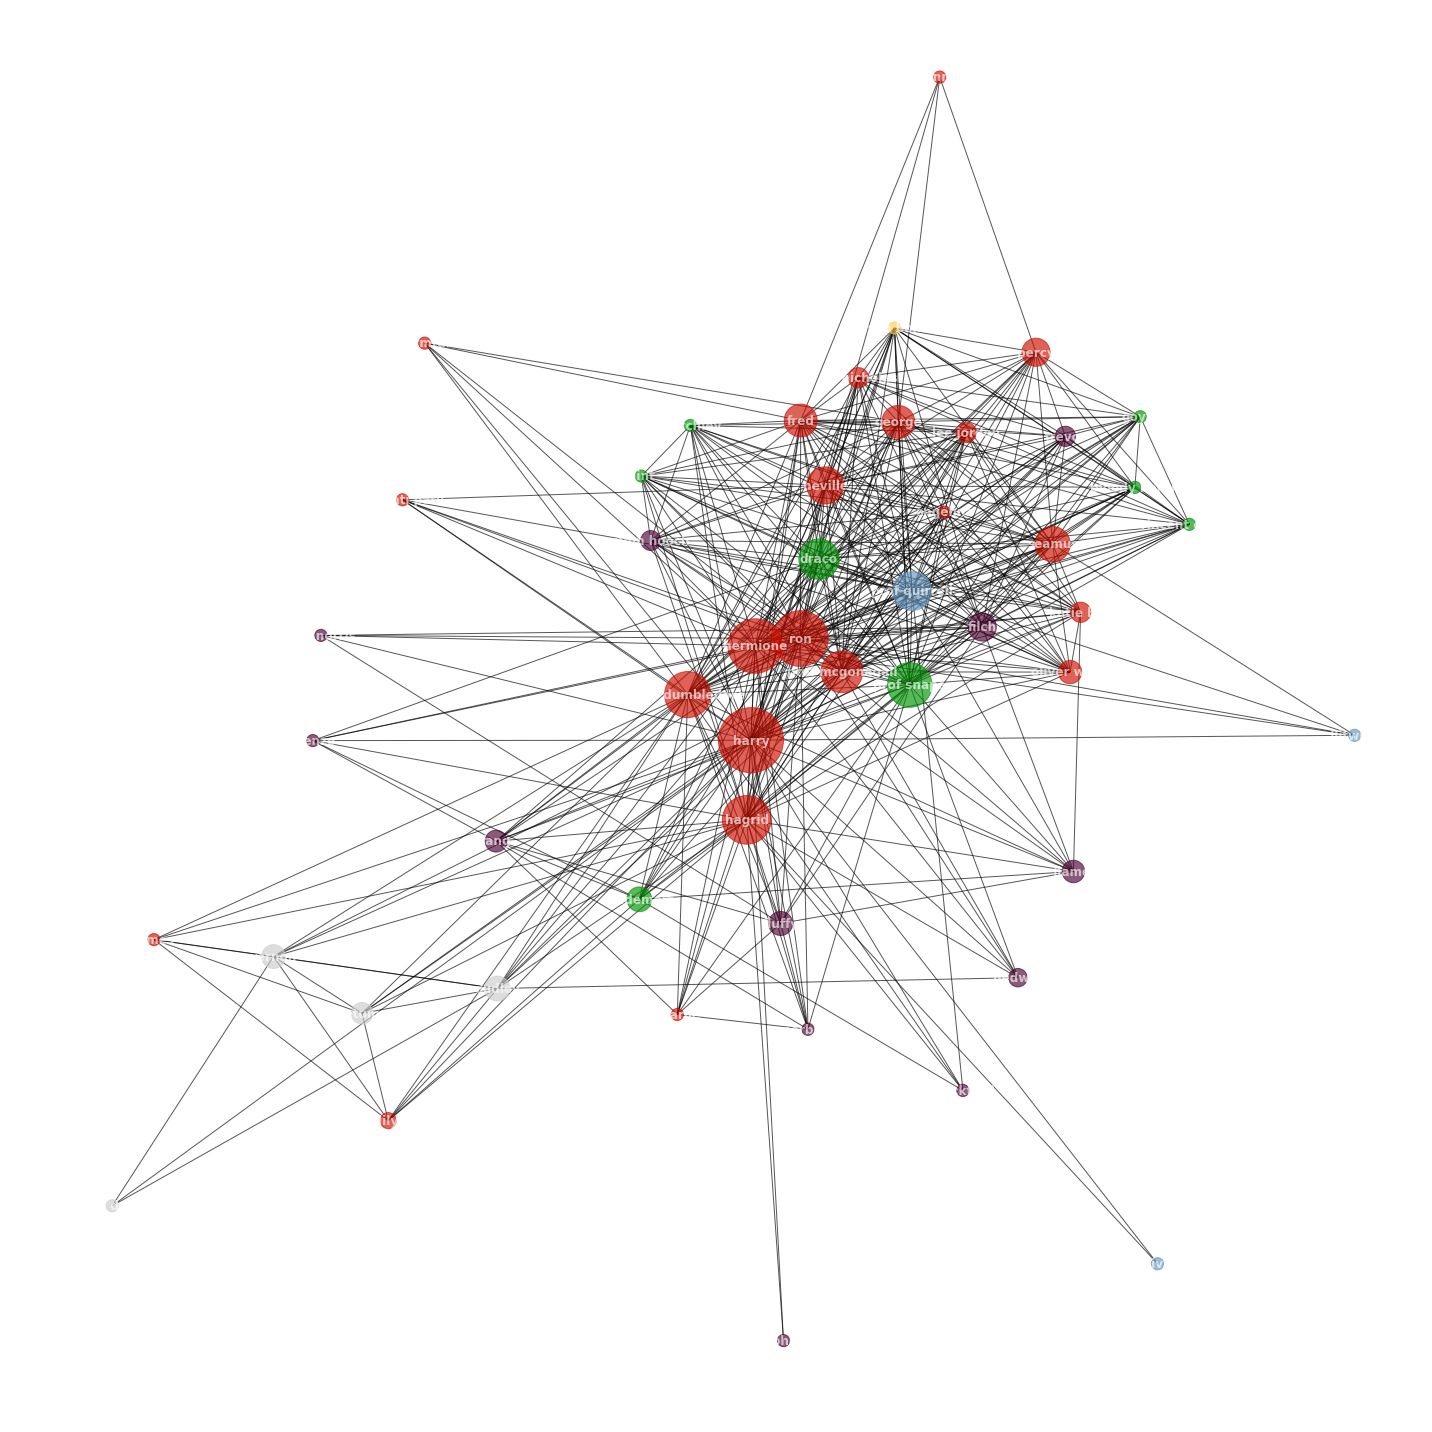

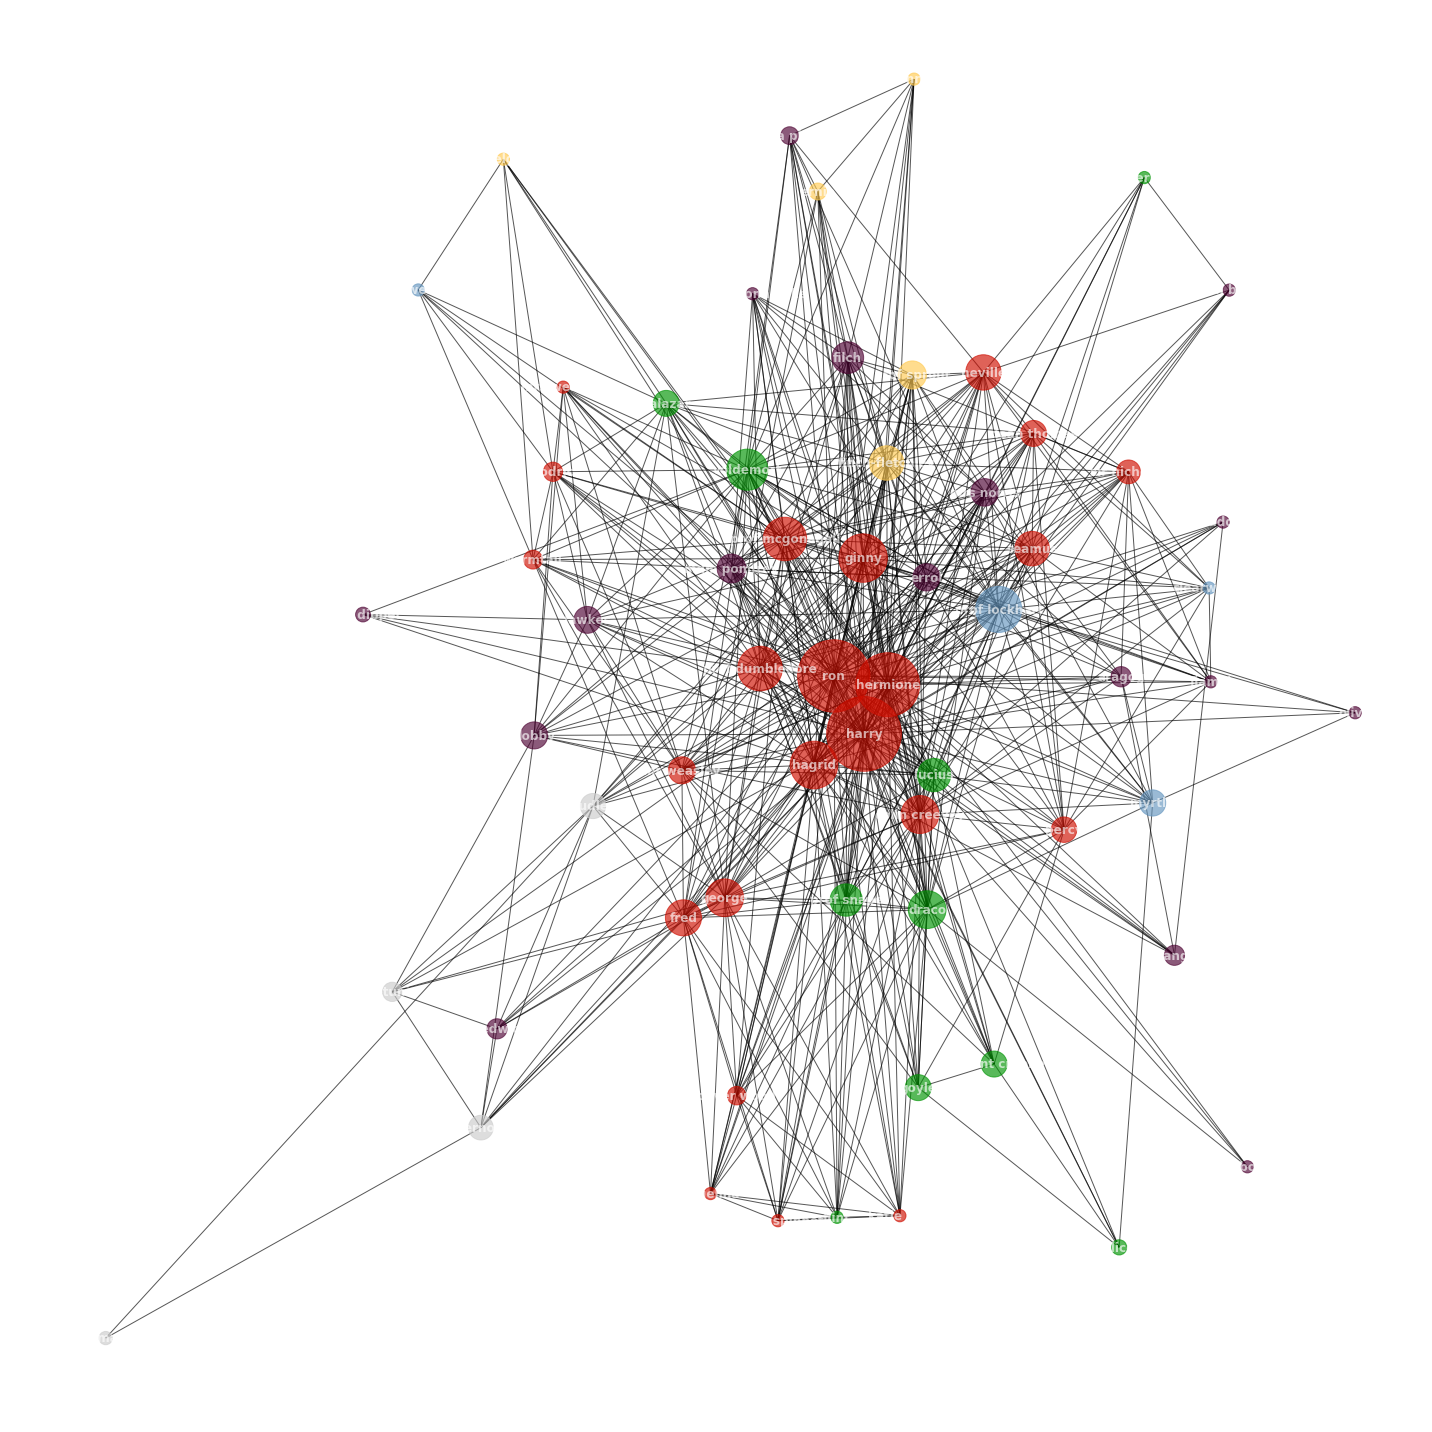

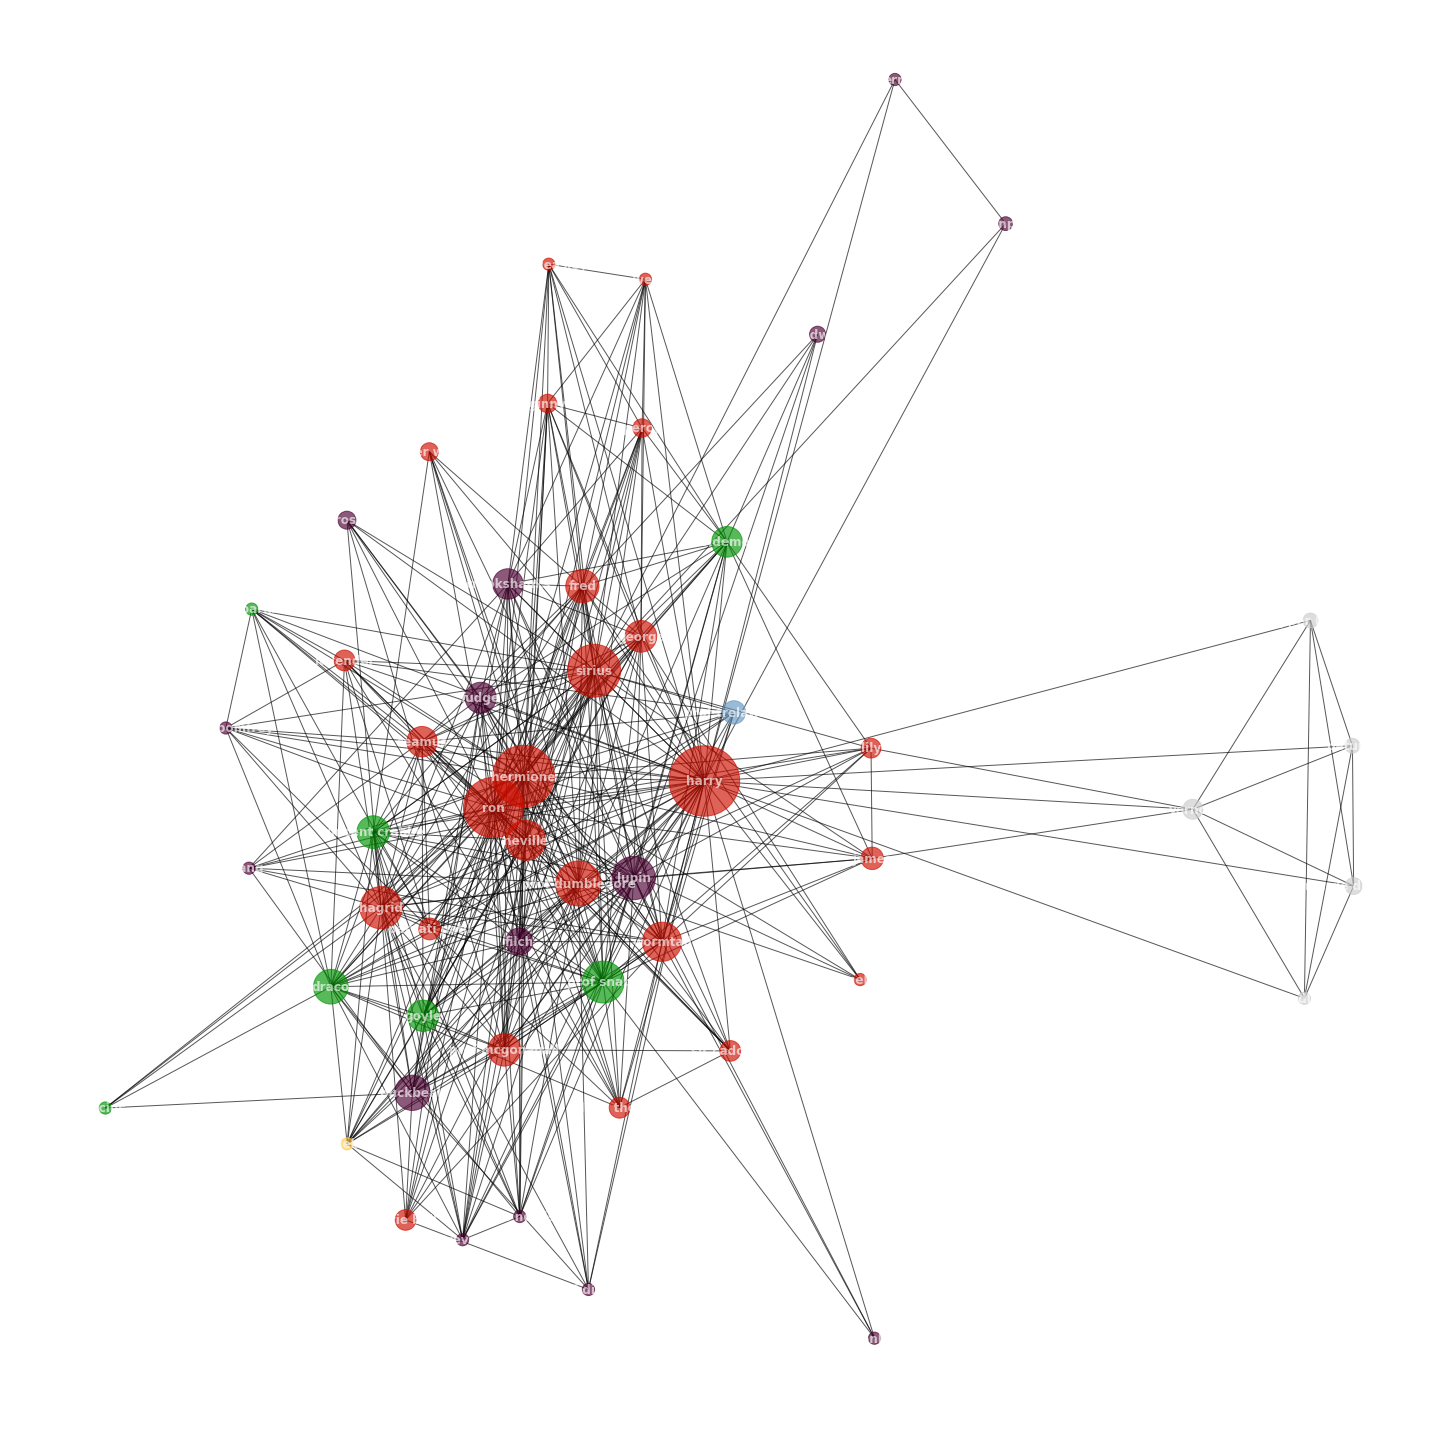

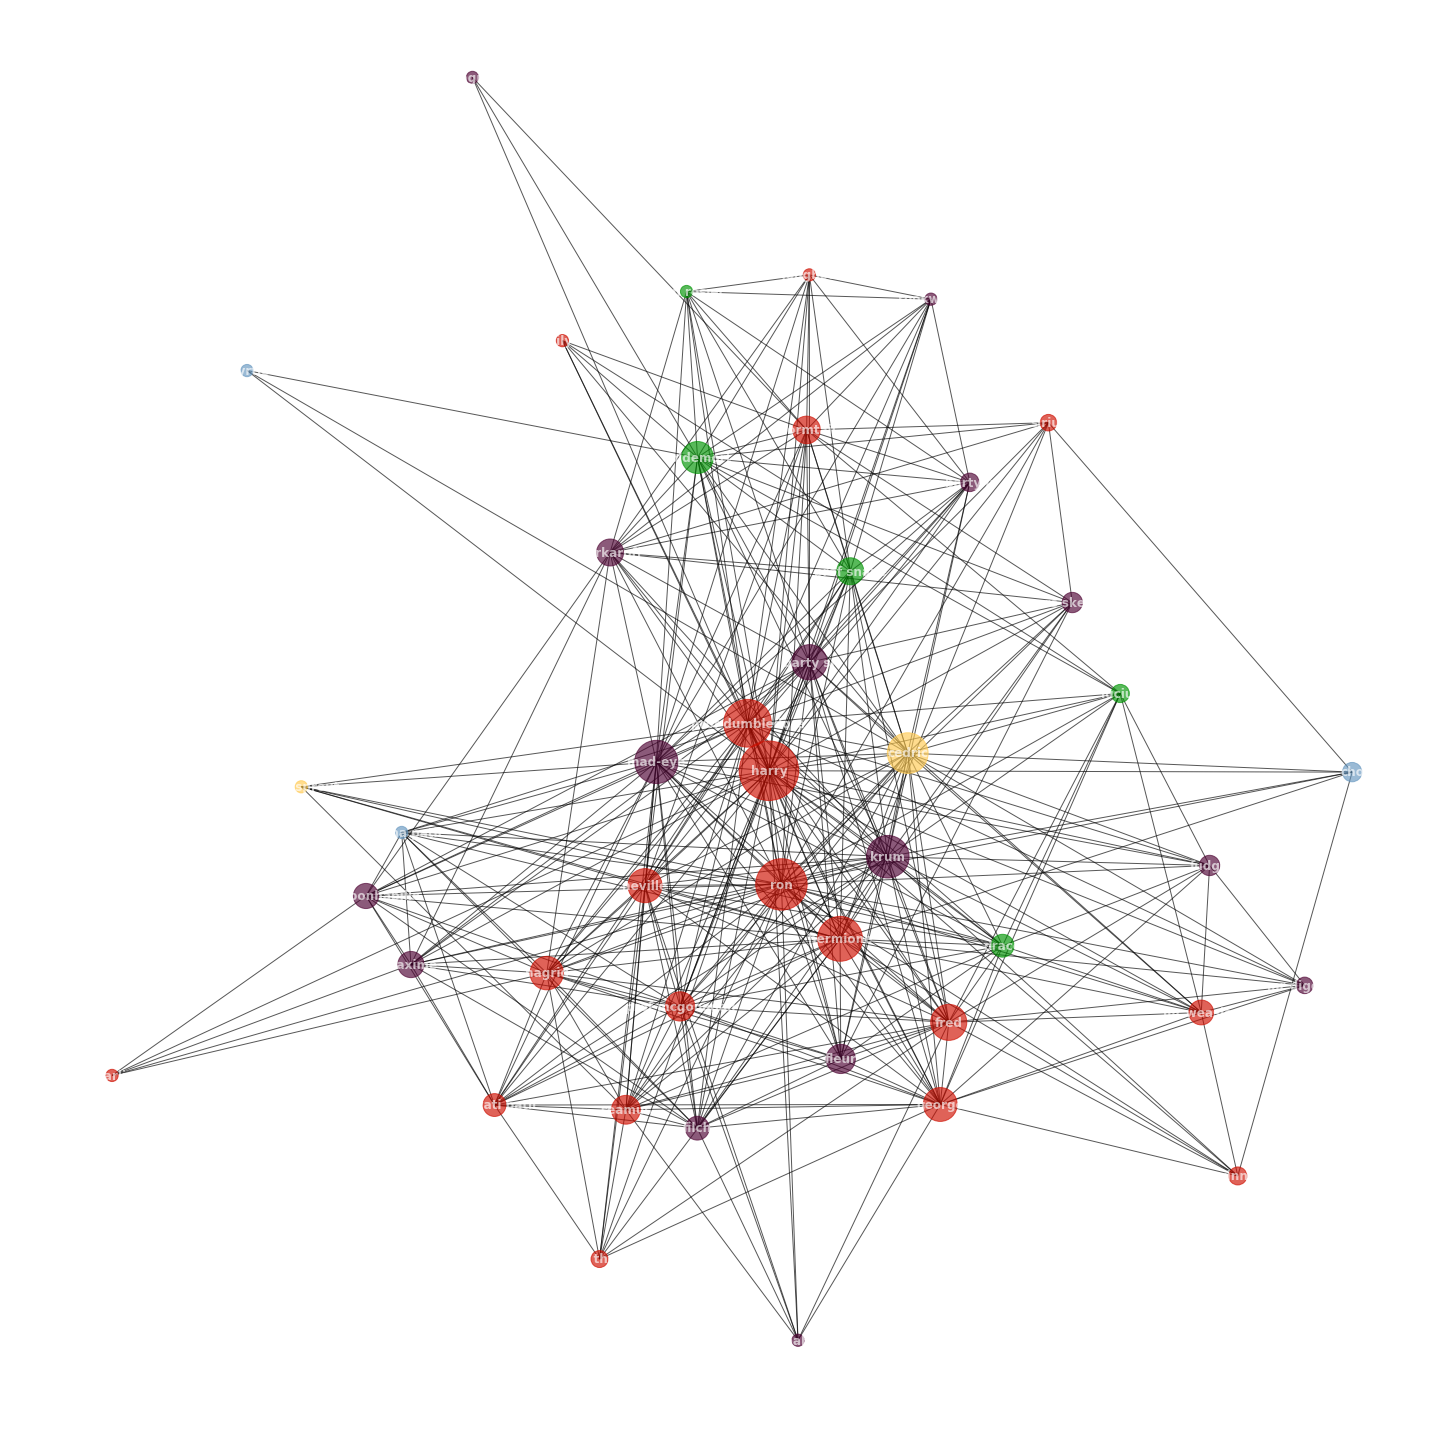

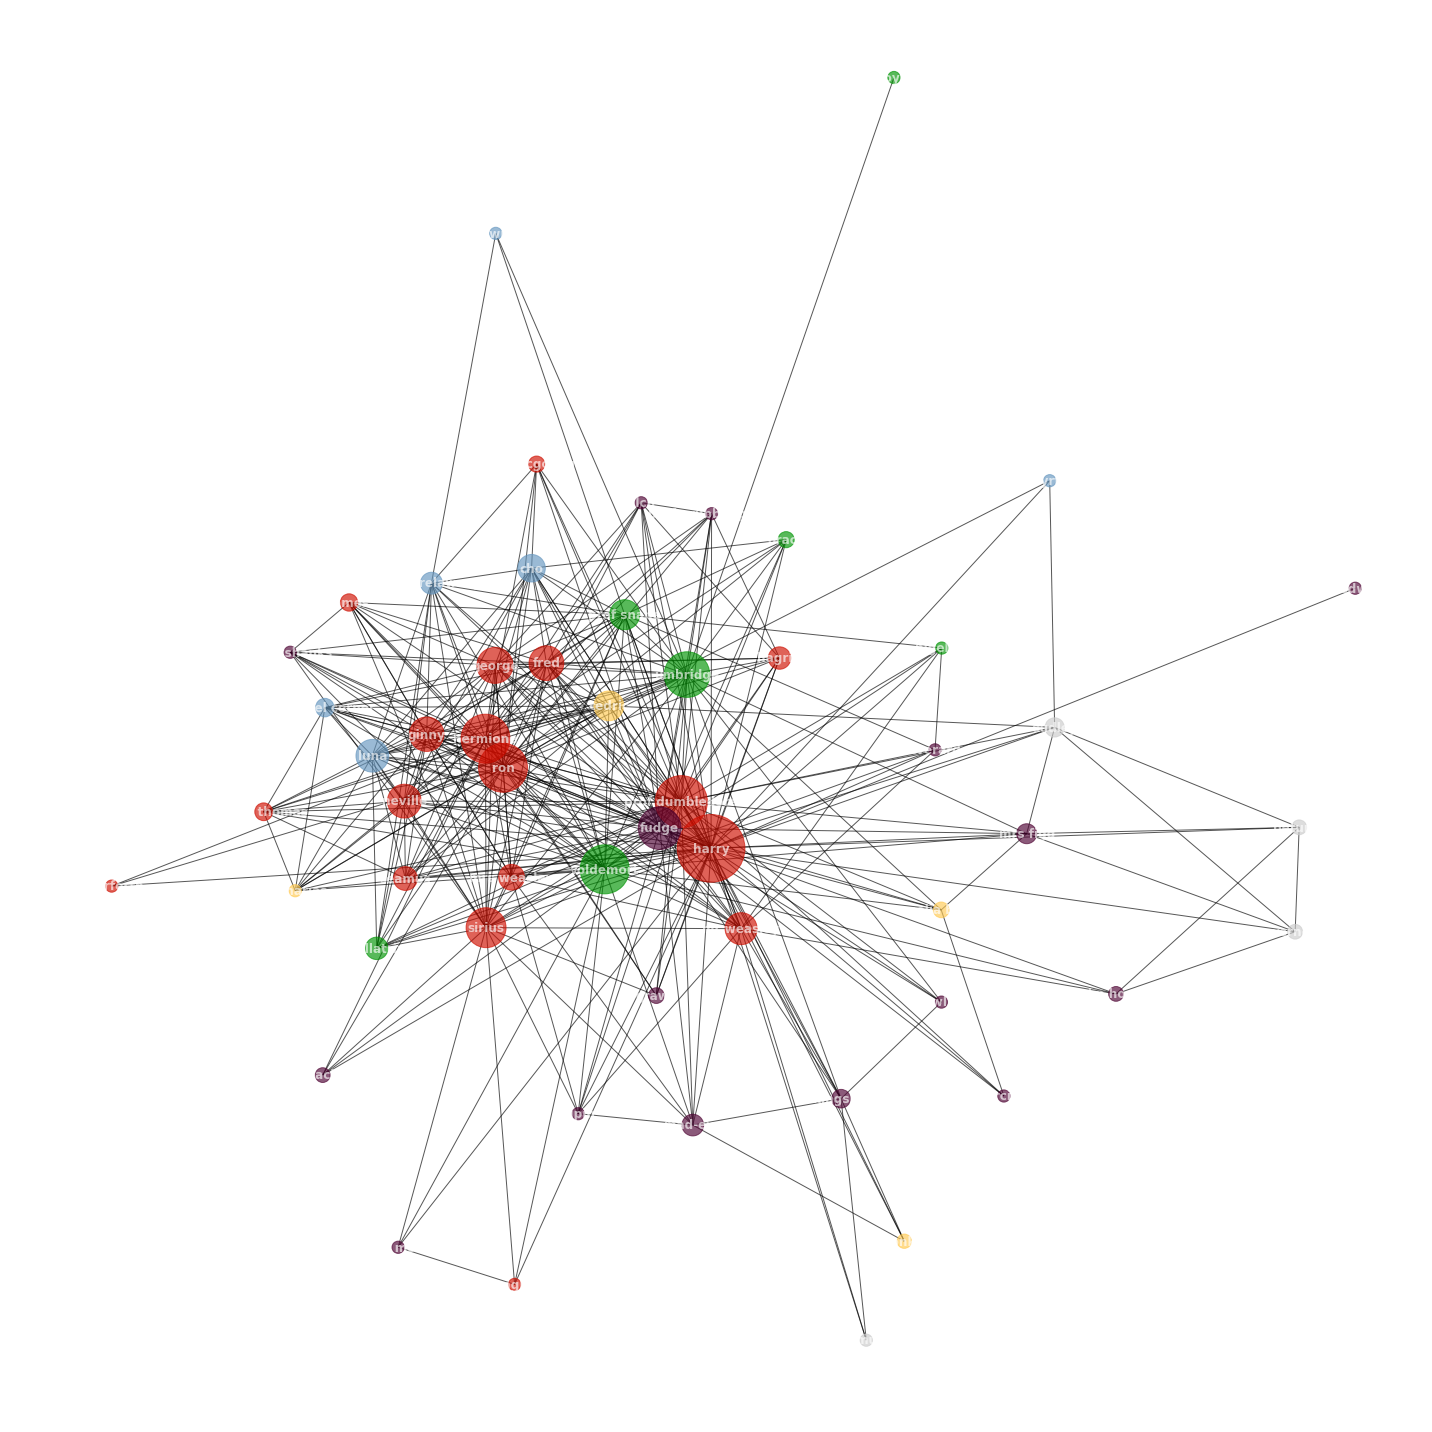

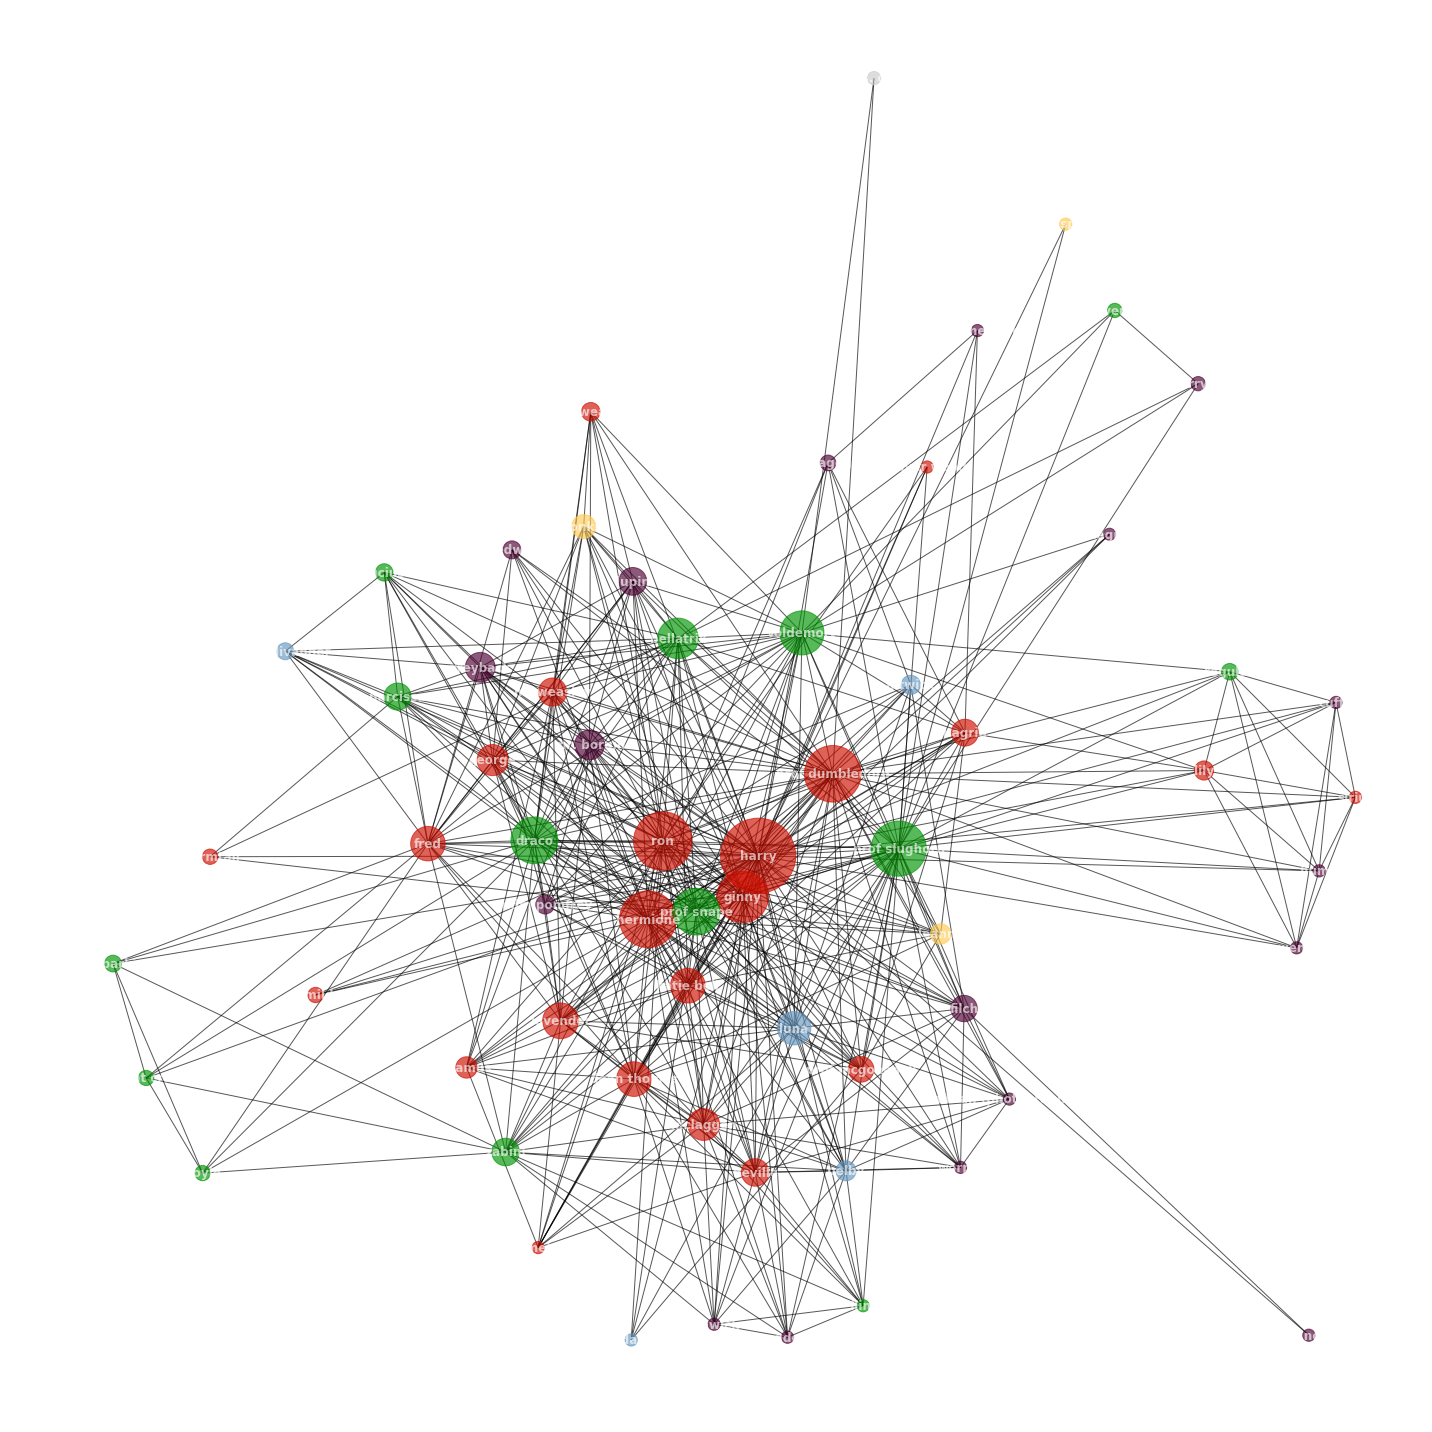

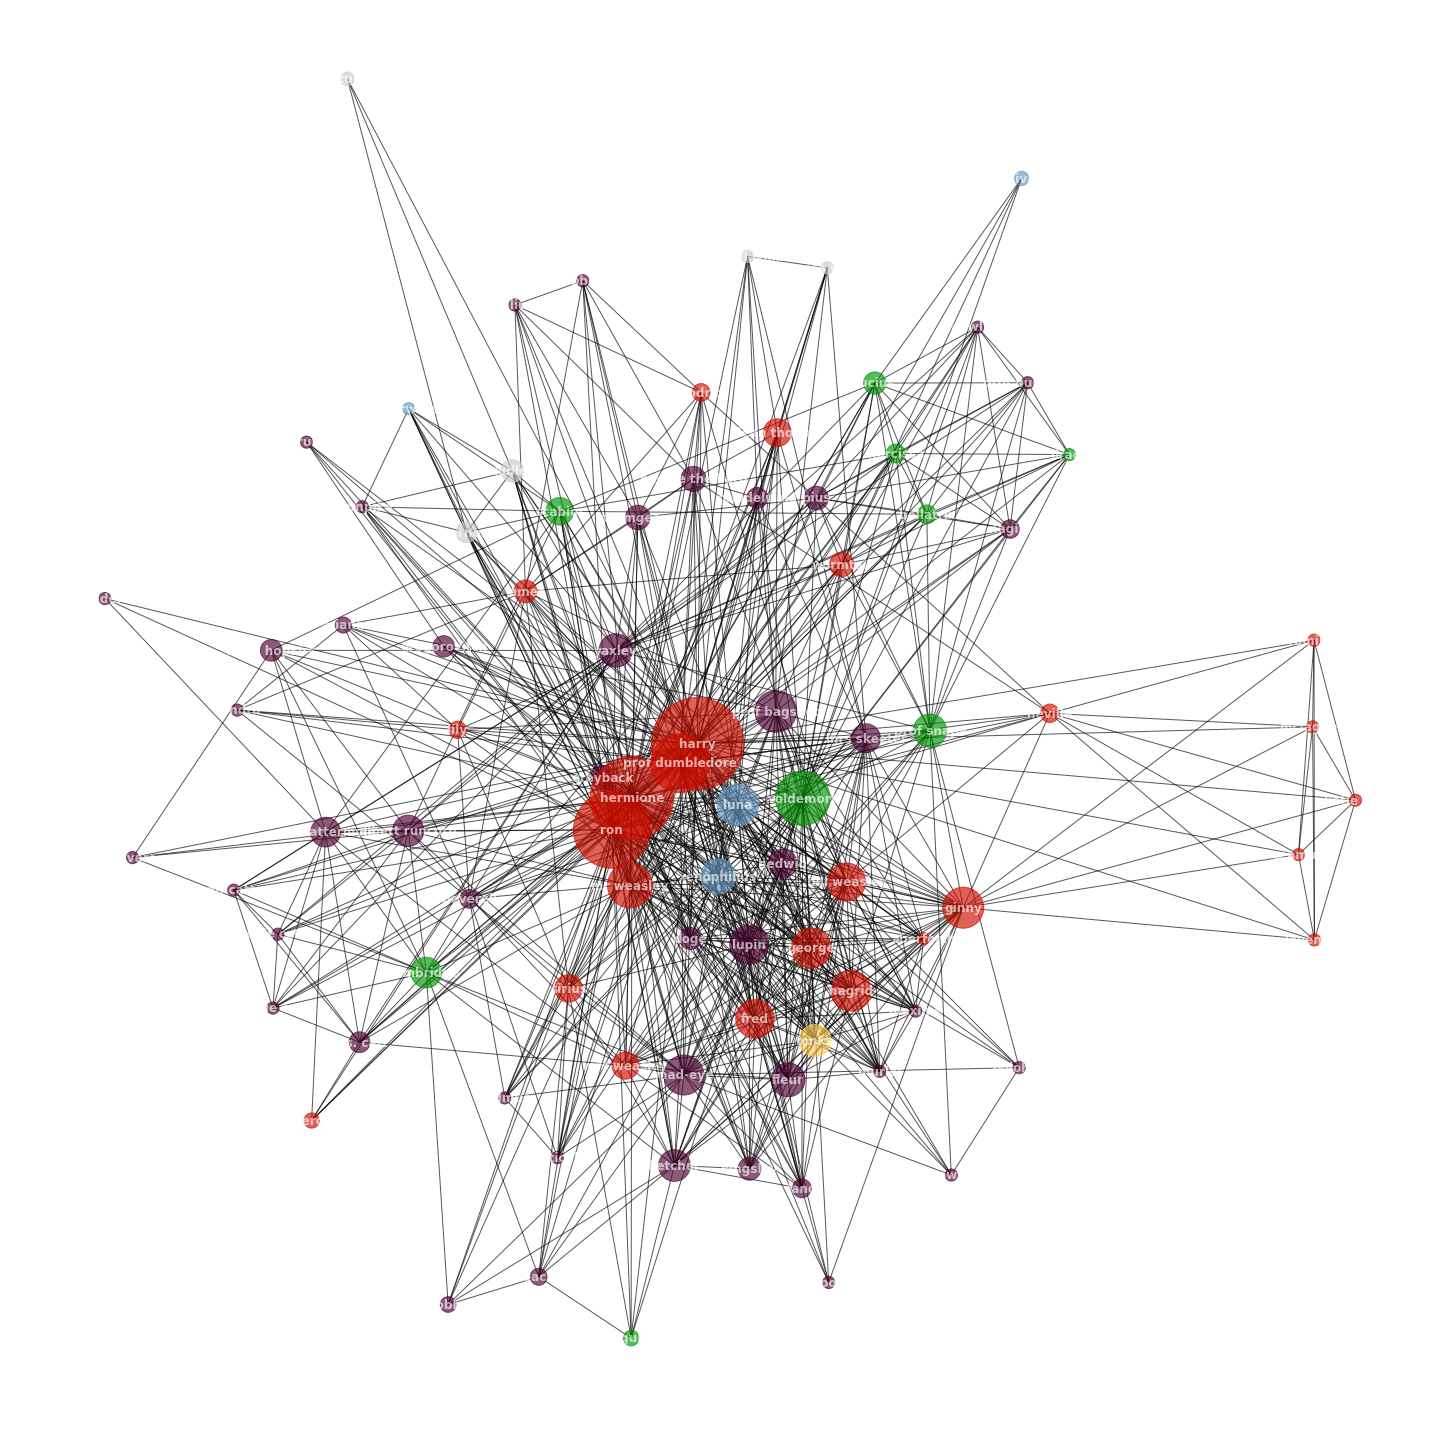

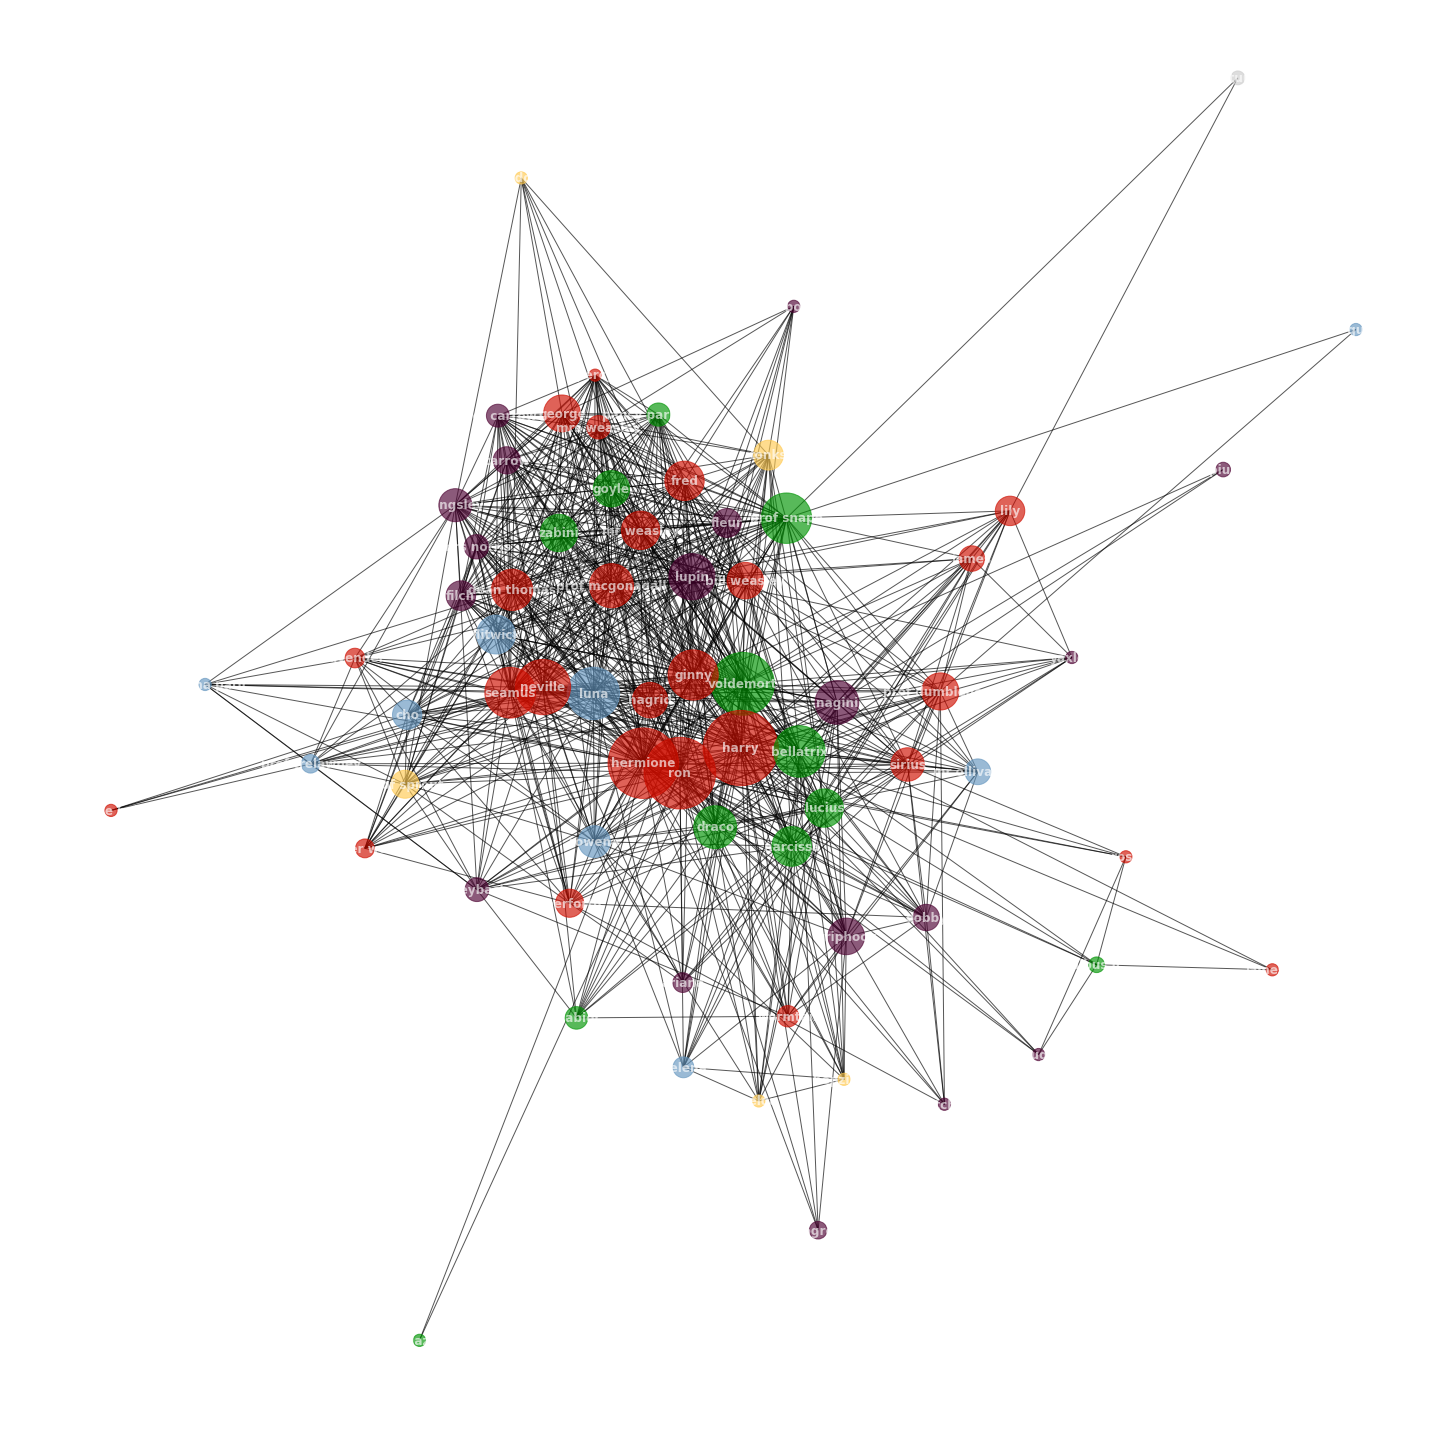

In [22]:
networks = []

for index , movie in enumerate(movies):
    G = generate_movie_network(movie.occurrences) 
    short_labels = {n:shortNames[n] for n in G.nodes}
    node_size = [150 + int(20 * G.degree(n) * log(total_occurences(movie.occurrences, n))) for n in G.nodes]
    color_map = [generate_node_color(n, info_dict) for n in G.nodes]
    display_network(G, node_size, color_map, save=save_plots, file_name="movie"+str(index+1), node_lables=short_labels)
    networks.append(G)

In [23]:
list(nx.all_neighbors(networks[4], "bob (muggle)"))

[u'arthur weasley', u'harry potter', u'kingsley shacklebolt']

Disadvantages of adding a note to each character taht is mentioned in a scene: the chatacter might only appear in one scene but could get an infalted degree if many other characters are mentioend in the scnene.

In [24]:
def plot_networks_over_time(nodes, edges, lables, save=False, file_name="plot"):
    fig = plt.figure()

    x = range(len(labels))
    y1 = nodes
    y2 = edges

    fig, ax1 = plt.subplots()
    #plt.ylim(30,140)

    color = gryffindor
    ax1.set_ylabel('nodes', color=color)
    ax1.plot(x, y1, color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)

    
    plt.xticks(x, labels,rotation=90)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = ravenclaw
    ax2.set_ylabel('edges', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color, alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.xticks(rotation=90)

    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save:
        plt.savefig("../plots/" + file_name + ".png", format="PNG", transparent=True,  bbox_inches = "tight")

    plt.show()
    

<Figure size 432x288 with 0 Axes>

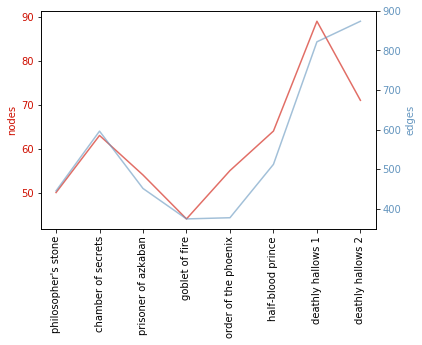

In [25]:
nodes = []
edges = []

for index, network in enumerate(networks):
    nodes.append(len(network.nodes))
    edges.append(len(network.edges))
    
labels = [
    "philosopher's stone", 
    "chamber of secrets", 
    "prisoner of azkaban", 
    "goblet of fire", 
    "order of the phoenix", 
    "half-blood prince", 
    "deathly hallows 1", 
    "deathly hallows 2"
]

plot_networks_over_time(nodes, edges, labels, save=False, file_name="degreeSeries")

In [26]:
with open("../characters.json") as f:
    characters = json.load(f) 

In [27]:
"Nicolas Flamel" in characters

True

In [28]:
degrees_by_movie = defaultdict(list)

for index, network in enumerate(networks):
    top_degrees = sorted(nx.degree(network), key=itemgetter(1), reverse=True)[:20]
    for node, degree in top_degrees:
        degrees_by_movie[node].append((index, degree))

In [29]:
labels = [
    "philosopher's stone", 
    "chamber of secrets", 
    "prisoner of azkaban", 
    "goblet of fire", 
    "order of the phoenix", 
    "half-blood prince", 
    "deathly hallows 1", 
    "deathly hallows 2"
]

In [30]:
def display_degree_series(x, y, title, color, labels, save=False, file_name="image"):
    fig = plt.figure()#(figsize=(8,20))
    axis = plt.gca()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.tick_params(axis='x', colors='white')
    axis.tick_params(axis='y', colors='white')
    axis.yaxis.label.set_color('white')
    axis.xaxis.label.set_color('white')
    axis.title.set_color("white") 
    axis.spines['bottom'].set_color('white')
    axis.spines['left'].set_color('white')
    plt.plot(x,y, marker="o", color=color)
    plt.title(title)
    plt.xlim(-1,len(labels))
    plt.ylim(0,max(y)+10)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("degree")
    plt.tight_layout()
    if save:
        plt.savefig("../plots/degrees/" + file_name + ".png", format="PNG", transparent=True,  bbox_inches = "tight")
    plt.show()

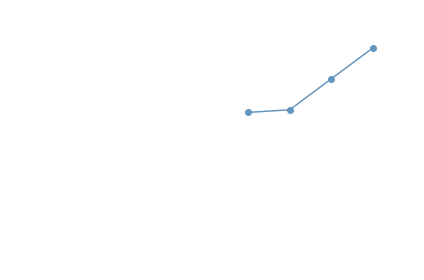

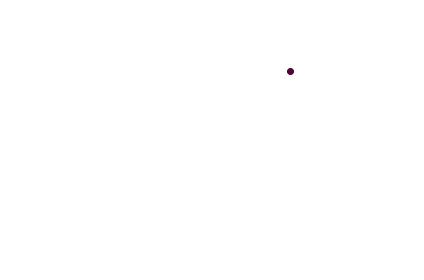

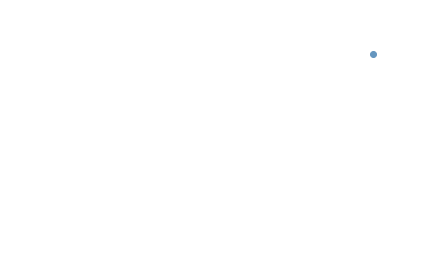

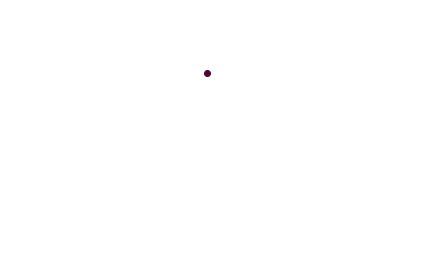

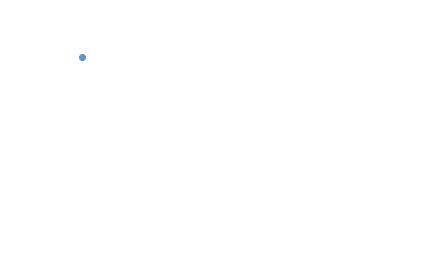

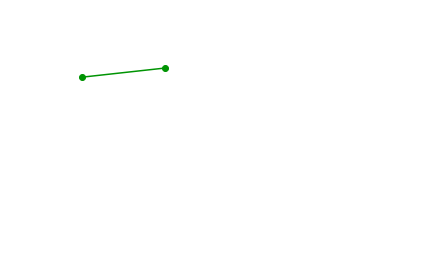

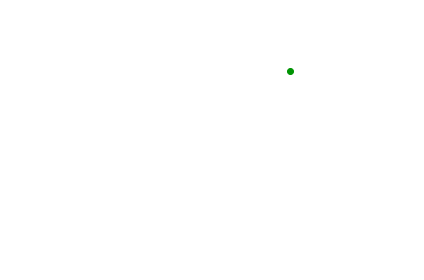

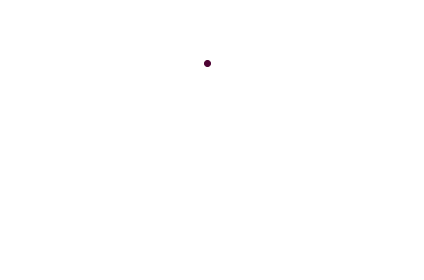

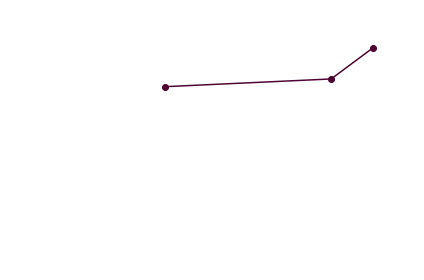

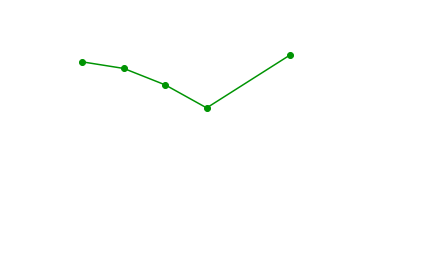

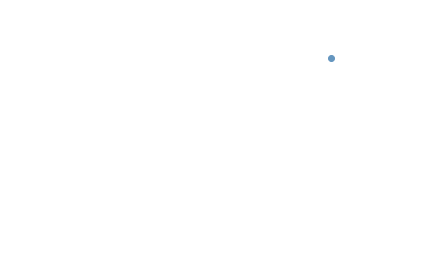

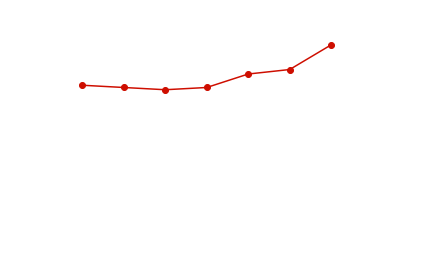

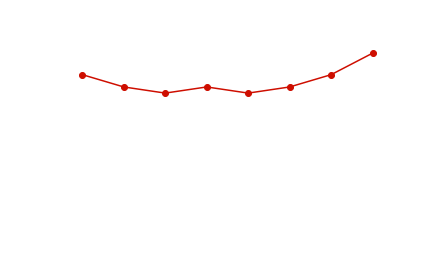

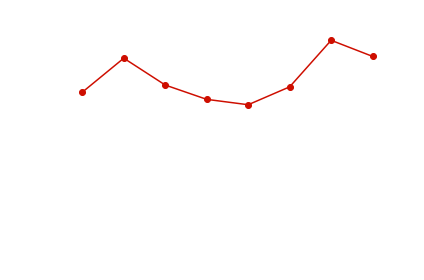

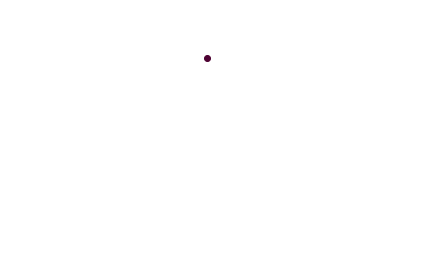

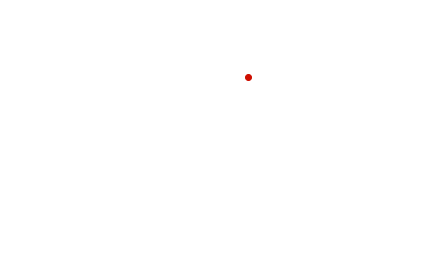

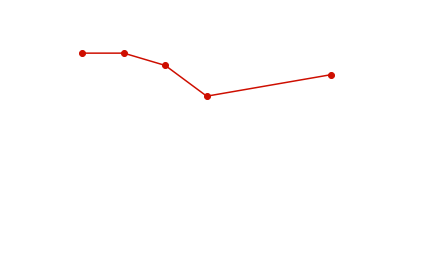

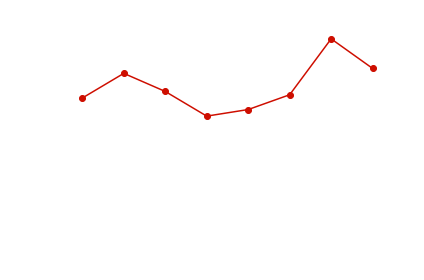

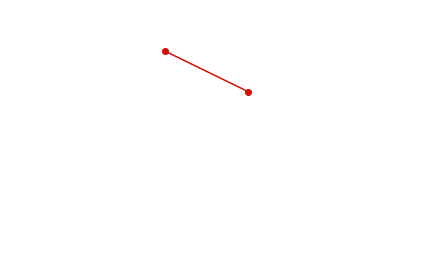

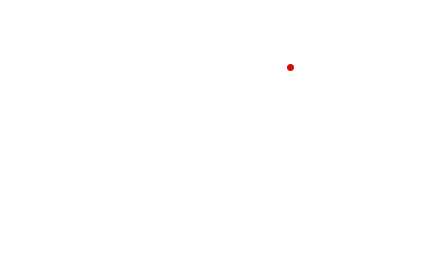

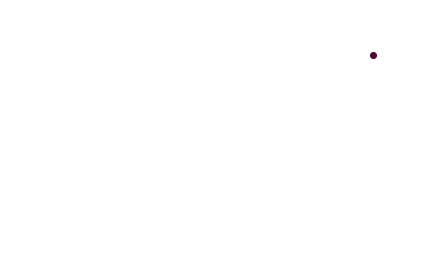

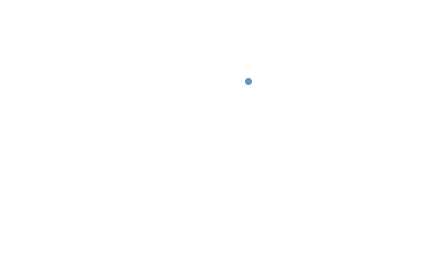

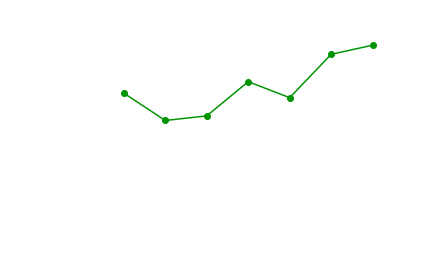

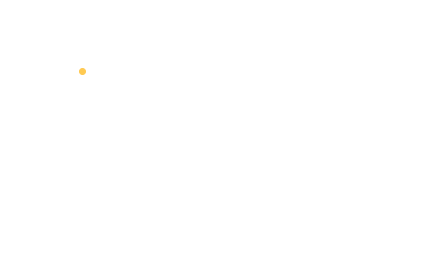

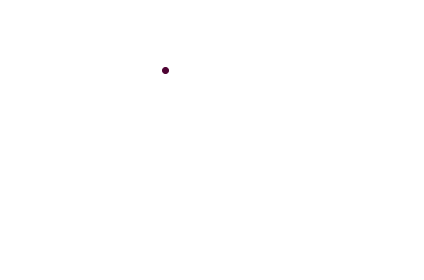

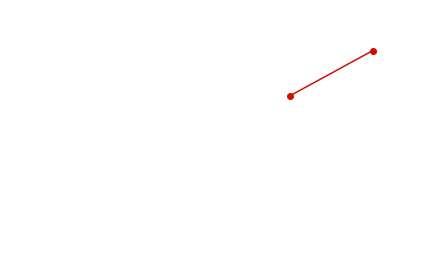

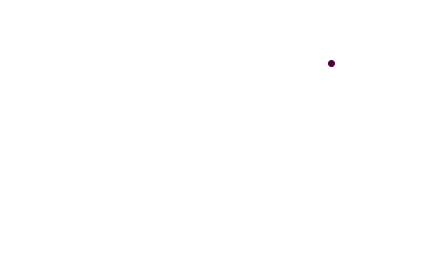

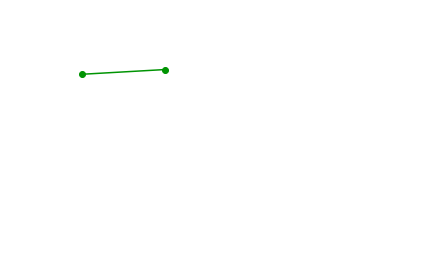

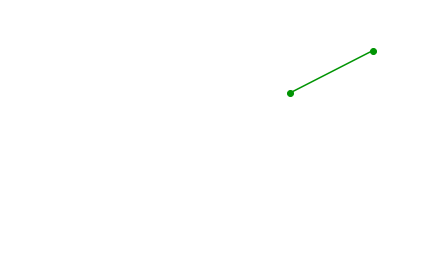

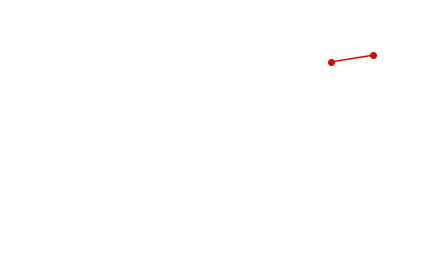

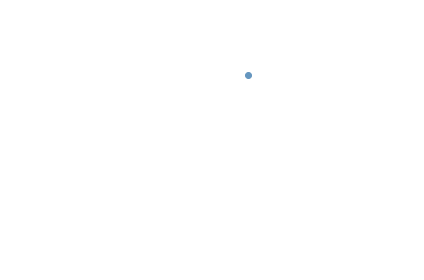

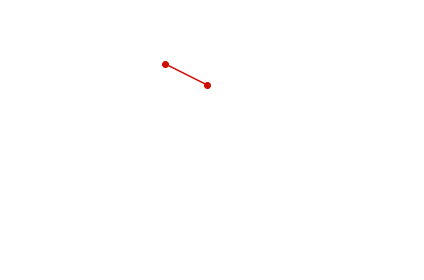

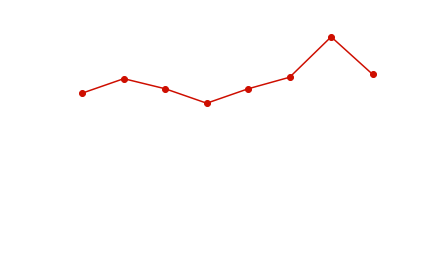

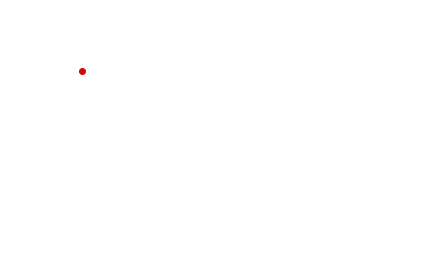

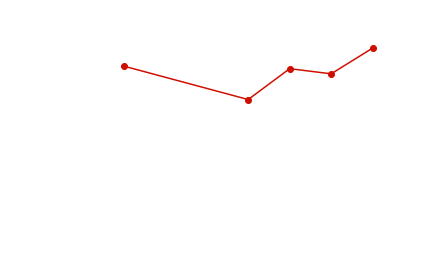

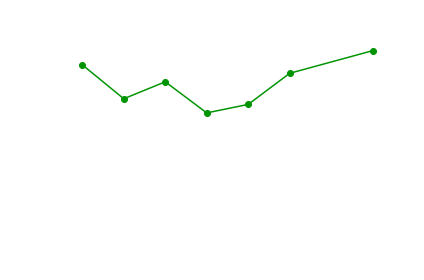

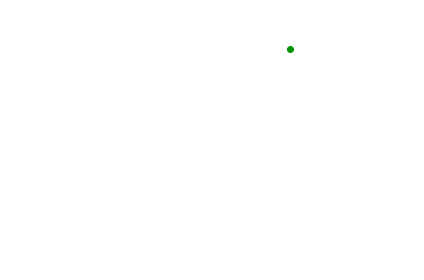

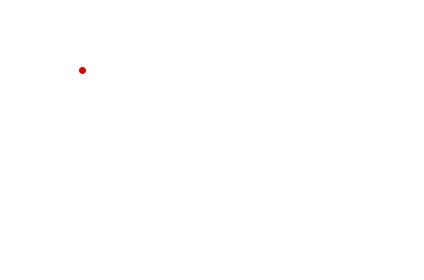

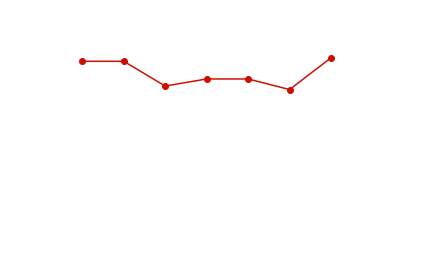

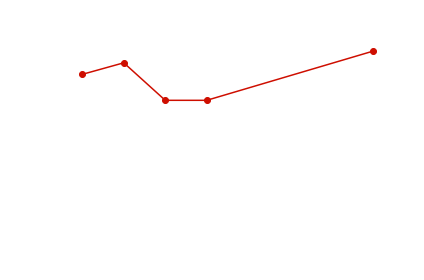

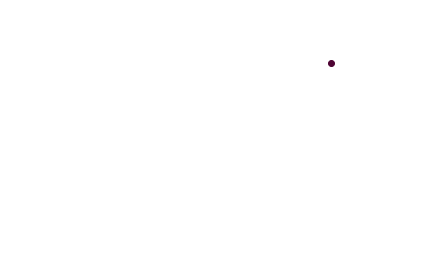

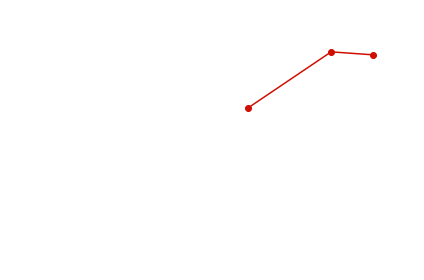

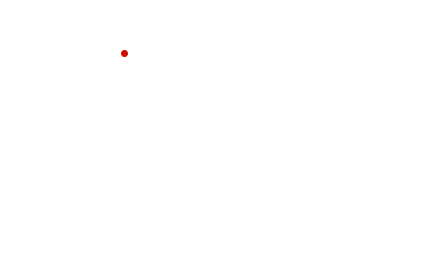

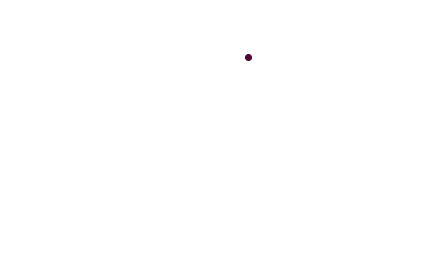

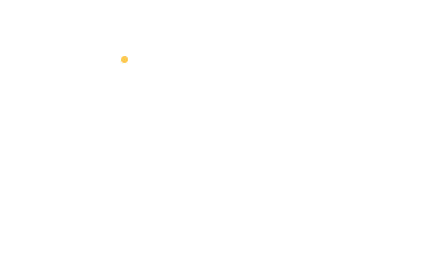

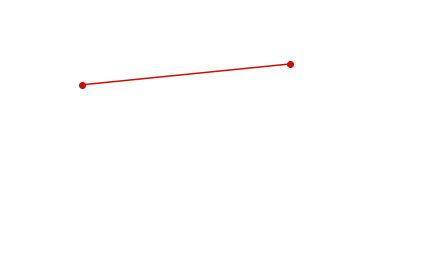

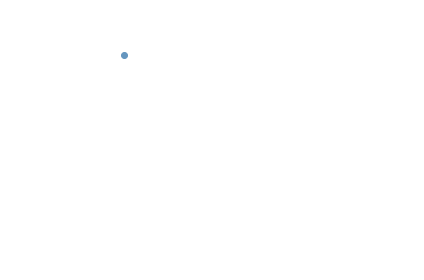

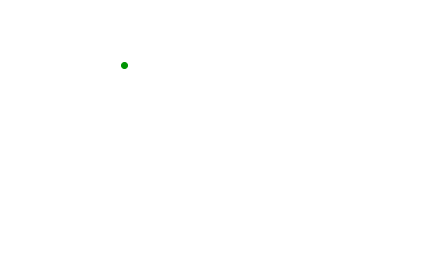

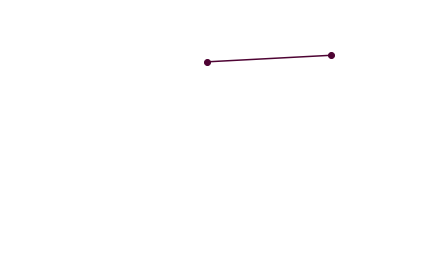

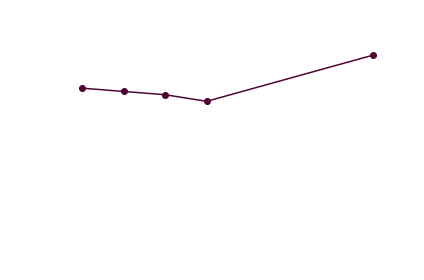

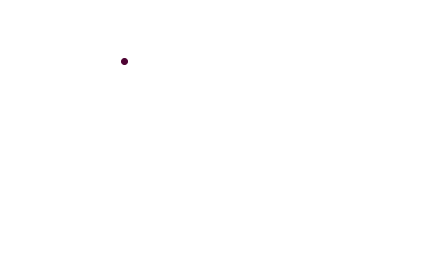

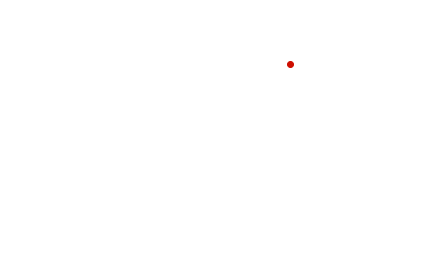

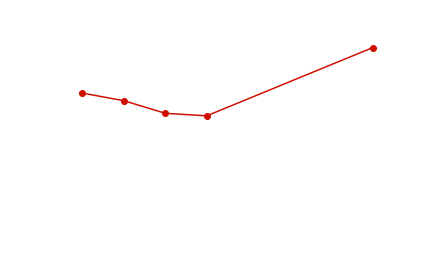

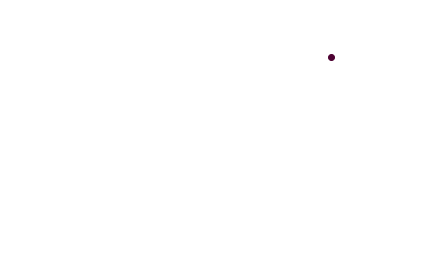

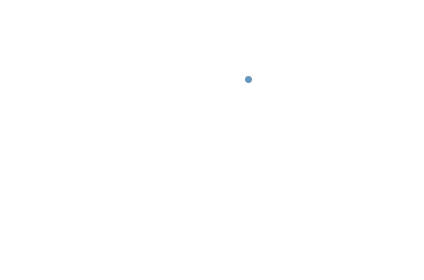

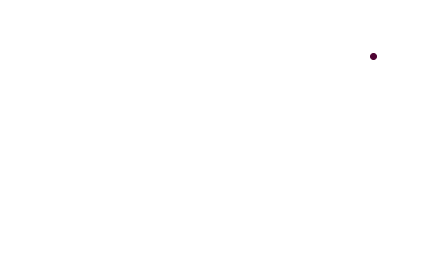

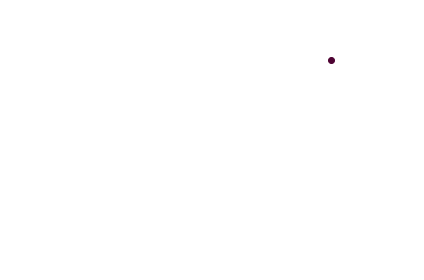

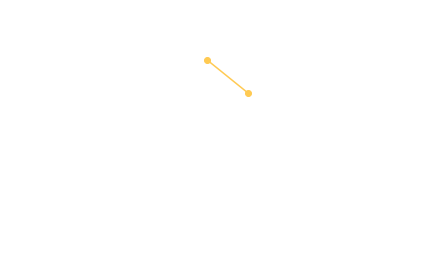

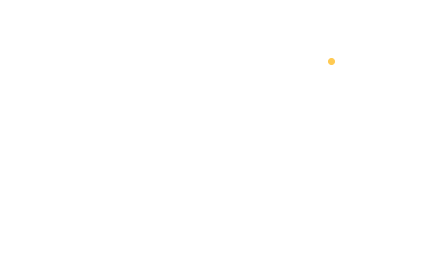

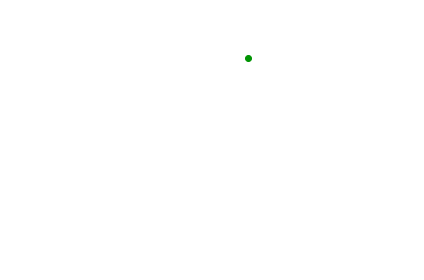

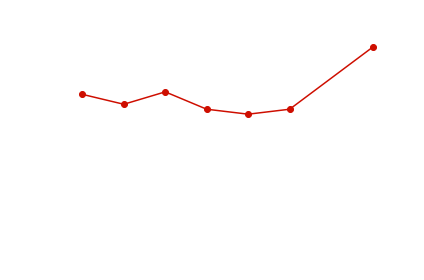

In [31]:
for index, (node, degrees) in enumerate(degrees_by_movie.iteritems()):
    x,y = zip(*degrees)
    color = generate_node_color(node, info_dict)
    name = "degree" + str(index+1)
    display_degree_series(x, y, node, color, labels, save=False, file_name=name)

In [32]:
json_dict_name = "shortNames.json"

with open(json_dict_name, "r") as json_dict:
    shortNames = json.load(json_dict)
    for network in networks:
        for node in network.nodes:
            if not shortNames.has_key(node):
                print "adding:", node
                shortNames[node] = node

with open(json_dict_name, "w") as json_dict:
    json.dump(shortNames, json_dict)

In [33]:
for i, movie in enumerate(movies):
    print "movie:", str(i+1)
    debug_scenes_by_character(movie, "bob ogden")

movie: 1
movie: 2
movie: 3
movie: 4
movie: 5
movie: 6
movie: 7
movie: 8


In [34]:
#missing_infos = []
for movie in movies:
    for scene, characters in movie.occurrences.iteritems():
        for character in characters:
            if not info_dict.has_key(character):
                print character
                #missing_infos.append(character)            

In [35]:
#missing_infos = []
for movie in movies:
    for scene, characters in movie.occurrences.iteritems():
        for character in characters:
            if "nearly-headless nick" in character:
                    print character

In [36]:
"""missing_info_dict = {}
for character in set(missing_infos):
    missing_info_dict[character] = {"house":"", "blood":"", "loyaty":[]}"""

'missing_info_dict = {}\nfor character in set(missing_infos):\n    missing_info_dict[character] = {"house":"", "blood":"", "loyaty":[]}'

In [37]:
"""with open("missingInfoDict.json", "w") as json_file:
    json.dump(missing_info_dict, json_file)"""

'with open("missingInfoDict.json", "w") as json_file:\n    json.dump(missing_info_dict, json_file)'

adding: amelia susan bones
adding: bob ogden
adding: oswald beamish
adding: wilhelmina grubbly-plank